# Packages and Dependencies

In [1]:
import torch
from torch import nn

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random

# If can't import, install torchinfo
try:
    from torchinfo import summary
except ImportError:
    print('\033[1m[ALERT]\033[0m torchinfo not found. Installing with pip...')
    !pip install torchinfo
    from torchinfo import summary

# If can't import, clone EnsNet repo and add it to Python path
try:

    from src import data_setup, utils, model, engine
except ImportError:
    print('\033[1m[ALERT]\033[0m Packages not found. Cloning from GitHub...')
    !git clone https://github.com/Jechen00/ensnet-pytorch.git
    sys.path.append('./ensnet-pytorch')

    from src import data_setup, utils, model, engine

# Set random seeds
utils.set_seed(0)
print(f'\033[1mDevice:\033[0m {utils.DEVICE}')

[ALERT] torchinfo not found. Installing with pip...
[ALERT] Packages not found. Cloning from GitHub...
Cloning into 'ensnet-pytorch'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 75 (delta 33), reused 57 (delta 19), pack-reused 0 (from 0)
Receiving objects: 100% (75/75), 906.62 KiB | 2.63 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Device: cuda


# Get MNIST Dataloaders

In [3]:
BATCH_SIZE = 100
NUM_WORKERS = 2

# This will download the MNIST dataset to ./mnist
train_dl, test_dl = data_setup.get_dataloaders(root = './mnist_data',
                                               batch_size = BATCH_SIZE,
                                               num_workers = NUM_WORKERS)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.44MB/s]


# Model Summary

In [4]:
num_classes = len(train_dl.dataset.classes)
ensnet = model.EnsNet(base_cnn = model.EnsNetBaseCNN,
                      subnet = model.EnsNetFCSN,
                      num_subnets = 10,
                      num_classes = num_classes)

X_dummy = torch.rand(100, 1, 28, 28) # Mimic MNIST batch size

summary(model = ensnet,
        input_size = X_dummy.shape,
        col_names = ['input_size', 'output_size', 'num_params'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #
EnsNet (EnsNet)                                         [100, 1, 28, 28]     [100, 10]            --
├─EnsNetBaseCNN (base_cnn)                              [100, 1, 28, 28]     [100, 10]            --
│    └─Sequential (cnn_body)                            [100, 1, 28, 28]     [100, 2000, 6, 6]    --
│    │    └─Sequential (cnn_block_1)                    [100, 1, 28, 28]     [100, 256, 14, 14]   370,560
│    │    └─Sequential (cnn_block_2)                    [100, 256, 14, 14]   [100, 2000, 6, 6]    24,340,848
│    └─Sequential (classifier)                          [100, 2000, 6, 6]    [100, 10]            --
│    │    └─Flatten (0)                                 [100, 2000, 6, 6]    [100, 72000]         --
│    │    └─Linear (1)                                  [100, 72000]         [100, 512]           36,864,512
│    │    └─ReLU (2)                                    [100, 512

# Model Training

In [5]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 15
PATIENCE = 10
MIN_DELTA = 0.001
SAVE_DIR = './saved_models'
MOD_NAME = 'ensnet_model.pth'

num_classes = len(train_dl.dataset.classes)
model_kwargs = {
    'base_cnn': model.EnsNetBaseCNN,
    'subnet': model.EnsNetFCSN,
    'num_subnets': 10,
    'num_classes': num_classes
}

ensnet = model.EnsNet(**model_kwargs).to(utils.DEVICE)
torch.compile(ensnet)

loss_fn = nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.Adam(params = ensnet.base_cnn.parameters(), lr = LEARNING_RATE)
subnets_optimizers = [torch.optim.Adam(params = subnet.parameters(), lr = LEARNING_RATE)
                      for subnet in ensnet.subnets]

# This will save model to ./saved_models
# Results are also saved as .pkl files in ./saved_models
cnn_res, subnets_res, ensemble_res = engine.train(ensnet = ensnet,
                                                  train_dl = train_dl,
                                                  test_dl = test_dl,
                                                  loss_fn = loss_fn,
                                                  cnn_optimizer = cnn_optimizer,
                                                  subnets_optimizers = subnets_optimizers,
                                                  num_epochs = NUM_EPOCHS,
                                                  patience = PATIENCE,
                                                  min_delta = MIN_DELTA,
                                                  device = utils.DEVICE,
                                                  save_dir = SAVE_DIR,
                                                  mod_name = MOD_NAME,
                                                  save_results = True)

[NOTE] The model and/or fit results will be saved to ./saved_models 

*************************
EPOCH 1
*************************
[UPDATE] Training base CNN; parameters of subnetworks are frozen.
[UPDATE] Training subnetworks; parameters of base CNN are frozen.
[CNN]         | train_loss = 0.2387     | train_acc = 0.9234     | test_loss = 2.4244     | test_acc = 0.9484    
[SUBNETS]     | avg_train_loss = 0.1176 | avg_train_acc = 0.9656 | avg_test_loss = 0.0288 | avg_test_acc = 0.9911
[FULL ENSNET] | ----------------------- | train_acc = 0.9836     | ---------------------- | test_acc = 0.9917    
[UPDATE] Adequate improvement in EnsNet test accuracy. Model saved.

*************************
EPOCH 2
*************************
[UPDATE] Training base CNN; parameters of subnetworks are frozen.
[UPDATE] Training subnetworks; parameters of base CNN are frozen.
[CNN]         | train_loss = 0.0945     | train_acc = 0.9709     | test_loss = 0.0287     | test_acc = 0.9915    
[SUBNETS]     | avg_t

# Plotting Test Accuracy

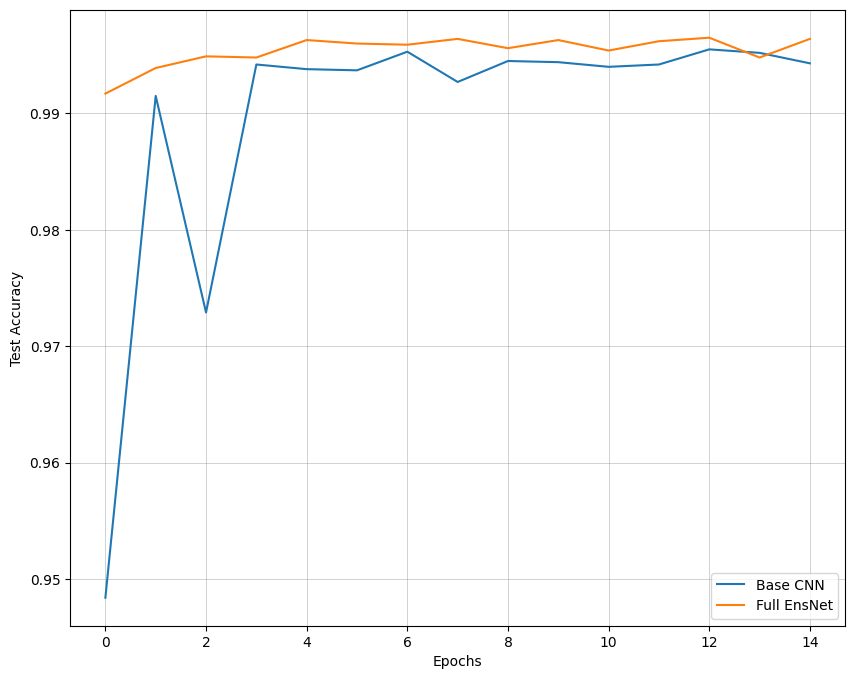

In [7]:
# Get results from .pkl files
base_name = os.path.splitext(MOD_NAME)[0]

results = {}
for key in ['cnn', 'subnets', 'ensemble']:
    with open(f'{SAVE_DIR}/{base_name}_{key}_res.pkl', 'rb') as f:
        results[key] = pickle.load(f)

cnn_res = results['cnn']
subnets_res = results['subnets']
ensemble_res = results['ensemble']

# Plotting test accuracy to observe effect of ensemble learning
epochs = range(0, len(cnn_res['test_acc']))

fig = plt.figure(figsize = (10, 8))

plt.plot(epochs, cnn_res['test_acc'], label = 'Base CNN')
plt.plot(epochs, ensemble_res['test_acc'], label = 'Full EnsNet')

plt.legend(loc = 4)
plt.ylabel('Test Accuracy')
plt.xlabel('Epochs')
plt.grid(color = 'gray', linewidth = 0.5, alpha = 0.5)
plt.show()

# Making Predictions

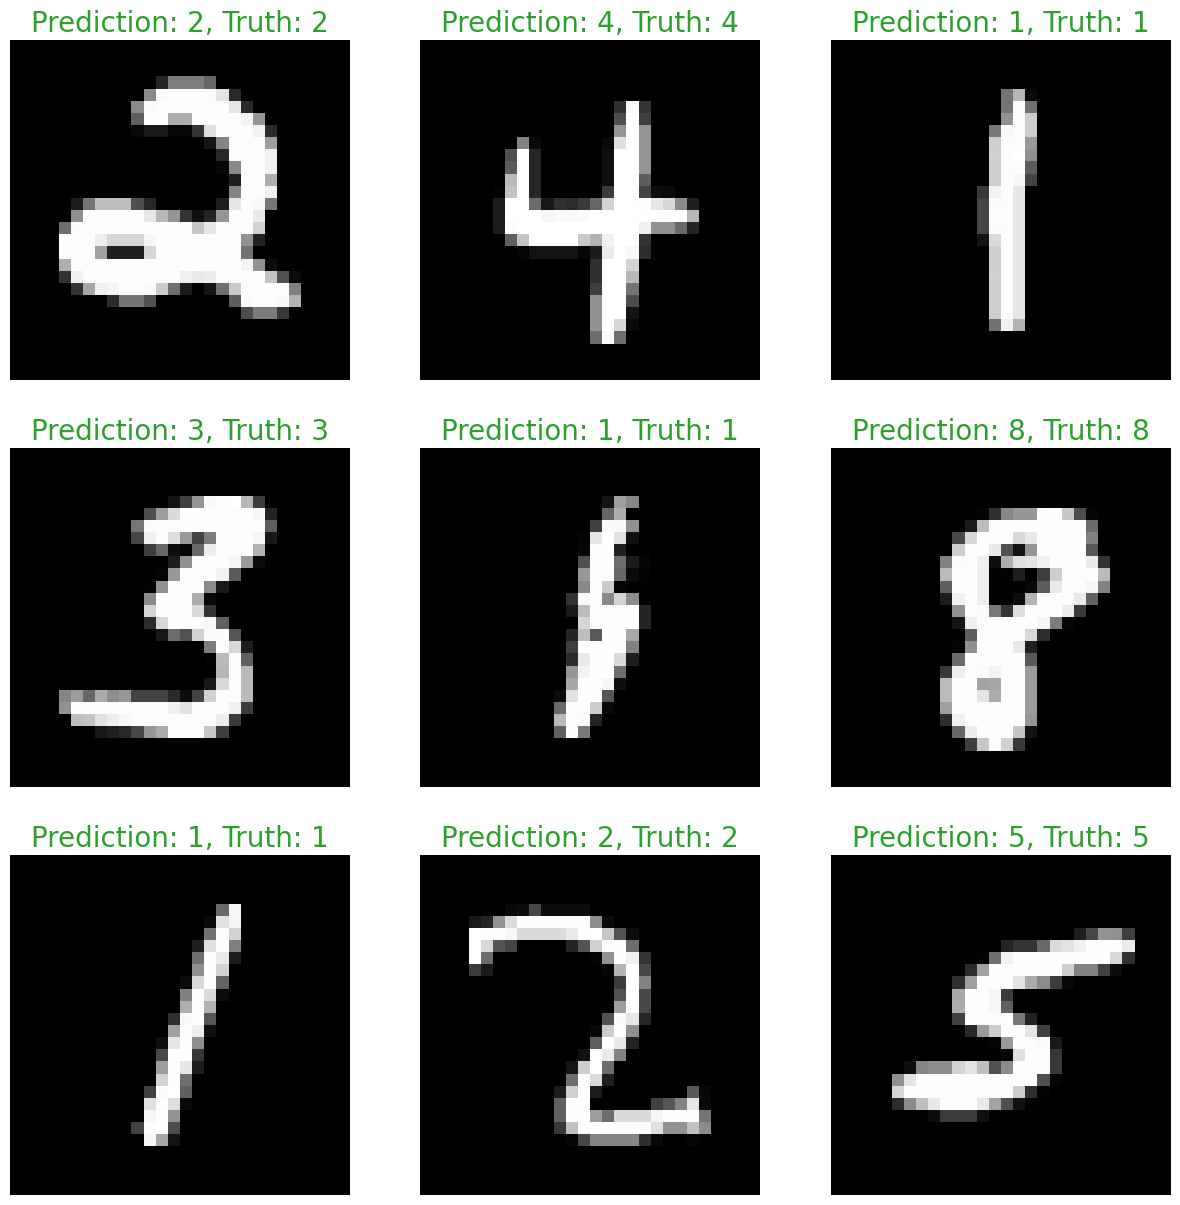

In [8]:
# Get random samples
test_data = list(test_dl.dataset)

num_samples = 9
rand_samples = random.sample(test_data, num_samples)

# Load model
saved_ensnet = model.EnsNet(**model_kwargs)

loaded_state_dict = torch.load(f'{SAVE_DIR}/{MOD_NAME}', map_location = 'cpu') # Load on CPU
saved_ensnet.load_state_dict(loaded_state_dict)
saved_ensnet.eval() # Set to evaluation mode

# Plot predictions
num_cols =3
num_rows = int(np.ceil(num_samples / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize = (5 * num_cols, 5 * num_rows))

flatten_axes = axes.flat

for i, (X, y) in enumerate(rand_samples):
    ax = flatten_axes[i]

    with torch.inference_mode():
        pred_label = saved_ensnet.predict(X.unsqueeze(0))

    clr = 'tab:green' if pred_label == y else 'tab:red'

    ax.imshow(X.permute(1, 2, 0).numpy(), cmap = 'grey')
    ax.set_title(f'Prediction: {pred_label.item()}, Truth: {y}',
                 fontsize = 20, color = clr)

for ax in flatten_axes:
    ax.axis(False)

# Individual Training Components

In [9]:
%%time
# CNN training step

LEARNING_RATE = 0.001
ensnet_test = model.EnsNet(**model_kwargs).to(utils.DEVICE)

loss_fn = nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.Adam(params = ensnet_test.base_cnn.parameters(),
                                 lr = LEARNING_RATE)

cnn_loss, cnn_acc = engine.cnn_train_step(ensnet = ensnet_test,
                                          dataloader = train_dl,
                                          loss_fn = loss_fn,
                                          optimizer = cnn_optimizer,
                                          device = utils.DEVICE)

CPU times: user 1min 29s, sys: 352 ms, total: 1min 30s
Wall time: 1min 33s


In [10]:
%%time
# subnets training step

LEARNING_RATE = 0.001
ensnet_test = model.EnsNet(**model_kwargs).to(utils.DEVICE)

loss_fn = nn.CrossEntropyLoss()
subnet_optimizers = [torch.optim.Adam(params = subnet.parameters(),
                                      lr = LEARNING_RATE)
                     for subnet in ensnet_test.subnets]

subnets_loss, subnets_acc = engine.subnets_train_step(ensnet = ensnet_test,
                                                      dataloader = train_dl,
                                                      loss_fn = loss_fn,
                                                      optimizers = subnet_optimizers,
                                                      device = utils.DEVICE)

CPU times: user 49.4 s, sys: 9.67 s, total: 59 s
Wall time: 1min 2s


In [11]:
%%time
# EnsNet testing step

ensnet_test = model.EnsNet(**model_kwargs).to(utils.DEVICE)

loss_fn = nn.CrossEntropyLoss()

test_res = engine.test_step(ensnet = ensnet_test,
                            dataloader = test_dl,
                            loss_fn = loss_fn,
                            device = utils.DEVICE)

CPU times: user 9.09 s, sys: 43.8 ms, total: 9.14 s
Wall time: 9.15 s


In [12]:
%%time
# EnsNet accuracy on training set

ensnet_test = model.EnsNet(**model_kwargs).to(utils.DEVICE)

train_acc = utils.get_ensemble_accuracy(ensnet = ensnet_test,
                                        dataloader = train_dl,
                                        device = utils.DEVICE)

CPU times: user 56.5 s, sys: 300 ms, total: 56.8 s
Wall time: 1min


In [13]:
%%time
# EnsNet accuracy on testing set

ensnet_test = model.EnsNet(**model_kwargs).to(utils.DEVICE)

test_acc = utils.get_ensemble_accuracy(ensnet = ensnet_test,
                                       dataloader = test_dl,
                                       device = utils.DEVICE)


CPU times: user 9.7 s, sys: 55.6 ms, total: 9.75 s
Wall time: 10.1 s
